In [9]:
import pandas as pd

import seaborn as sns

from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

import scipy.stats as sps

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import sklearn.cluster as sklc
import sklearn.metrics as sklm
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.cm
import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [10]:
import statsmodels
print(statsmodels.__version__)

0.13.2


# read the file

In [13]:
birth_data = pd.read_csv('https://raw.githubusercontent.com/Gzrayyy/CASA007_Assessment/main/dt.csv')

In [14]:
birth_data['working_hour'] = birth_data['working_hour'].astype(np.float64)
birth_data['house_price'] = birth_data['house_price'].astype(np.float64)

In [15]:
birth_data.head()

,year,month,birth_number,CPI,employ_rate(%),unemploy_male(%),unemploy_famale(%),gender_pay_gap(%),working_hour,house_price
0,2011,Jan,4851,4.0000,71.0000,9.2000,6.6000,10.5000,36.4000,"150,490.0000"
1,2011,Feb,4382,4.4000,71.0000,9.3000,6.8000,10.5000,36.4000,"147,862.0000"
2,2011,Mar,4797,4.0000,70.8000,9.1000,6.5000,10.5000,36.4000,"142,143.0000"
3,2011,Apr,4765,4.5000,71.4000,8.9000,6.7000,10.5000,36.3000,"151,501.0000"
4,2011,May,4984,4.5000,71.6000,8.6000,6.8000,10.5000,36.3000,"154,317.0000"


In [16]:
birth_data_numeric = pd.get_dummies(birth_data)

In [17]:
birth_data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                132 non-null    int64  
 1   birth_number        132 non-null    int64  
 2   CPI                 132 non-null    float64
 3   employ_rate(%)      132 non-null    float64
 4   unemploy_male(%)    132 non-null    float64
 5   unemploy_famale(%)  132 non-null    float64
 6   gender_pay_gap(%)   132 non-null    float64
 7   working_hour        132 non-null    float64
 8   house_price         132 non-null    float64
 9   month_Apr           132 non-null    uint8  
 10  month_Aug           132 non-null    uint8  
 11  month_Dec           132 non-null    uint8  
 12  month_Feb           132 non-null    uint8  
 13  month_Jan           132 non-null    uint8  
 14  month_Jul           132 non-null    uint8  
 15  month_Jun           132 non-null    uint8  
 16  month_Ma

In [18]:
birth_data_final = birth_data_numeric.drop(['month_Jan'], axis=1)

# double check the result
birth_data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                132 non-null    int64  
 1   birth_number        132 non-null    int64  
 2   CPI                 132 non-null    float64
 3   employ_rate(%)      132 non-null    float64
 4   unemploy_male(%)    132 non-null    float64
 5   unemploy_famale(%)  132 non-null    float64
 6   gender_pay_gap(%)   132 non-null    float64
 7   working_hour        132 non-null    float64
 8   house_price         132 non-null    float64
 9   month_Apr           132 non-null    uint8  
 10  month_Aug           132 non-null    uint8  
 11  month_Dec           132 non-null    uint8  
 12  month_Feb           132 non-null    uint8  
 13  month_Jul           132 non-null    uint8  
 14  month_Jun           132 non-null    uint8  
 15  month_Mar           132 non-null    uint8  
 16  month_Ma

Text(0.5, 1.0, 'Correlation Matrix')

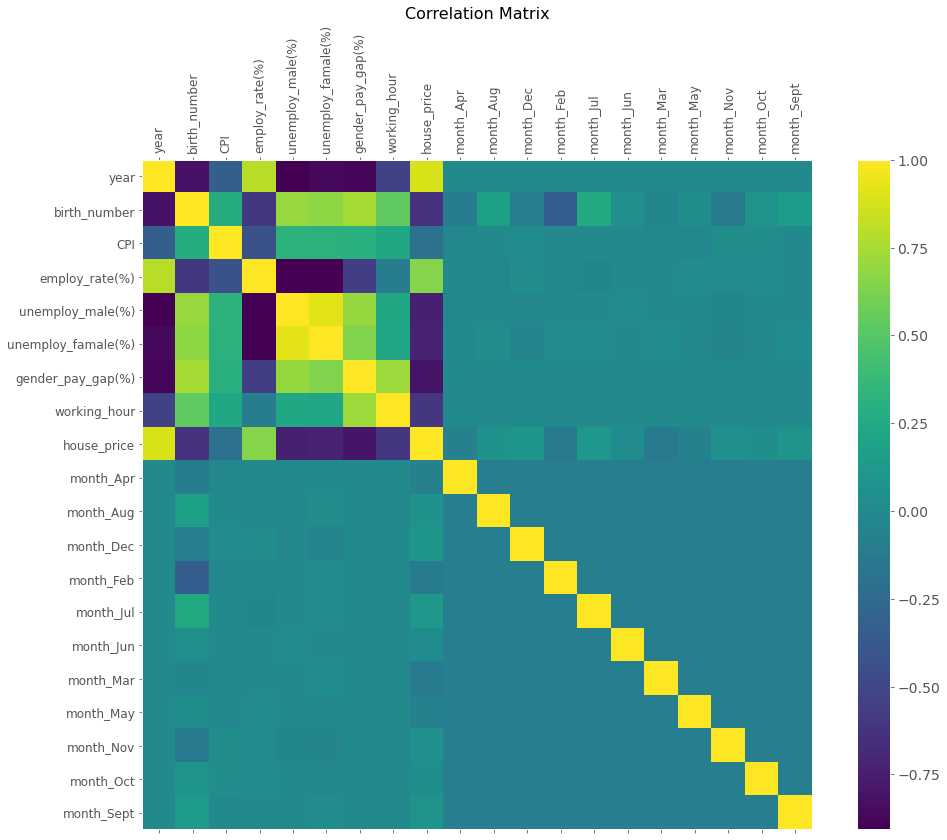

In [19]:
df = birth_data_final
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(16, 12))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=12, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# Using VIF

In [20]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [22]:
birth_data_VIF = drop_column_using_vif_(birth_data_final.drop('birth_number', axis=1))

Dropping: year
Dropping: unemploy_male(%)
Dropping: employ_rate(%)
Dropping: house_price


In [23]:
birth_data_VIF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CPI                 132 non-null    float64
 1   unemploy_famale(%)  132 non-null    float64
 2   gender_pay_gap(%)   132 non-null    float64
 3   working_hour        132 non-null    float64
 4   month_Apr           132 non-null    uint8  
 5   month_Aug           132 non-null    uint8  
 6   month_Dec           132 non-null    uint8  
 7   month_Feb           132 non-null    uint8  
 8   month_Jul           132 non-null    uint8  
 9   month_Jun           132 non-null    uint8  
 10  month_Mar           132 non-null    uint8  
 11  month_May           132 non-null    uint8  
 12  month_Nov           132 non-null    uint8  
 13  month_Oct           132 non-null    uint8  
 14  month_Sept          132 non-null    uint8  
dtypes: float64(4), uint8(11)
memory usage: 5.7 KB


In [26]:
model_birth_data = sm.OLS(endog=birth_data_final['birth_number'], exog=sm.add_constant(birth_data_VIF)).fit()
model_birth_data.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           birth_number   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     59.55
Date:                Mon, 09 Jan 2023   Prob (F-statistic):           3.43e-47
Time:                        13:10:39   Log-Likelihood:                -826.36
No. Observations:                 132   AIC:                             1685.
Df Residuals:                     116   BIC:                             1731.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -34.7364    470.735     -0.074      0.941    -967.086     897.613
CPI                   -4.4913      9.563     -0.470      0.639     -23.433      14.450
unemploy_famale(%)   103.8186     11.629      8.928      0.000      80.786     126.851
gender_pay_gap(%)    122.2248     25.847      4.729      0.000      71.032     173.418
working_hour          76.6295     16.800      4.561      0.000      43.355     109.904
month_Apr            -26.3952     57.612     -0.458      0.648    -140.503      87.712
month_Aug            305.3678     57.619      5.300      0.000     191.246     419.489
month_Dec             12.1676     57.757      0.211      0.834    -102.227     126.562
month_Feb           -322.8498     57.606     -5.604      0.000    -436.945    -208.754
month_Jul            403.3820     57.610      7.002      0.000     289.277     517.487
month_Jun            174.4002     57.629      3.026      0.003      60.258     288.542
month_Mar             48.0013     57.612      0.833      0.406     -66.107     162.110
month_May            166.4442     57.631      2.888      0.005      52.299     280.590
month_Nov            -24.4321     57.739     -0.423      0.673    -138.791      89.927
month_Oct            208.2608     57.665      3.612      0.000      94.047     322.474
month_Sept           277.0253     57.616      4.808      0.000     162.910     391.141
==============================================================================
Omnibus:                        7.171   Durbin-Watson:                   0.919
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.799
Skew:                          -0.490   Prob(JB):                       0.0334
Kurtosis:                       3.526   Cond. No.                     1.51e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Residual Analysis

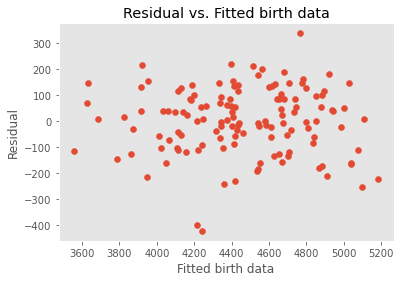

In [27]:
plt.scatter(model_birth_data.fittedvalues, model_birth_data.resid)
plt.xlabel('Fitted birth data')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted birth data')
plt.show()